<a href="https://colab.research.google.com/github/c-labropoulos/NN-for-lithological-segmentation/blob/main/toRaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [51]:
#!gdalinfo --version
!pip install geopandas
!pip install rasterio
!pip install pyshp
from osgeo import gdal
from osgeo import ogr
import rasterio
import geopandas as gpd
import shapefile as shp
import os
import matplotlib.pyplot as plt
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
import numpy as np


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:


def labelcreation(folder_path):
    """
    This function reads shapefiles from a given folder and extracts unique labels from the specified column.
    
    Parameters:
    folder_path (str): The path to the folder containing the shapefiles.
    
    Returns:
    dict: A dictionary mapping integers to unique labels found in the shapefiles.
    """
    # Create an empty set to store unique labels
    unique_labels = set()

    # Iterate over the files in the folder
    for file_name in os.listdir(folder_path):
        # Process only shapefiles
        if file_name.endswith(".shp"):
            # Create the full file path
            file_path = os.path.join(folder_path, file_name)
            
            # Read the shapefile as a geodataframe
            gdf = gpd.read_file(file_path)
            
            # Extract the labels from the specified column and add them to the set
            labels = set(gdf["labels_Lit"]) # replace "labels_Lit" with the name of the column containing the labels in your shapefile
            unique_labels = unique_labels.union(labels)

    # Create a dictionary mapping integers to unique labels
    label_dict = {i: label for i, label in enumerate(unique_labels)}

    return label_dict

# Define the folder path containing shapefiles
folder_path = "/content/drive/MyDrive/LithDatasSHP"

# Call the labelcreation function to extract unique labels
unique_labels = labelcreation(folder_path)

# Print the dictionary of unique labels
print(unique_labels)

# Save the labels to a CSV file. Using pandas for this will make it easier and more efficient.
import pandas as pd

df = pd.DataFrame(list(unique_labels.items()), columns=['pixel_value', 'class_name'])
df.to_csv("/content/drive/MyDrive/class_mapping.csv", index=False)


{0: 'Sxistolithoi', 1: 'Koites Potamon', 2: 'Kollouvia Flisxi', 3: 'Gnesioi', 4: 'Tritogeneis apotheseis', 5: 'Granitis', 6: 'Dolites', 7: 'Not available', 8: 'Konoi Apotheseon', 9: 'Kollouvia Asvestolithon', 10: 'Allouvia', 11: 'Peridotites kai Gavroi', 12: 'Miktos Flisxis', 13: 'Argilikos Flisxis kai Keratolithoi', 14: 'Kollouvia Gneusion', 15: 'Psamitikos Flisxis', 16: 'Skliroi asvestolithoi', 17: nan}


In [53]:
def lists_for_rasterize(shppath, tiffpath):
    """
    This function searches the given directories for shapefiles and raster files,
    and creates corresponding lists of file paths and names.
    
    Parameters:
    shppath (str): The path to the directory containing the shapefiles.
    tiffpath (str): The path to the directory containing the raster files.
    
    Returns:
    tuple: A tuple containing four lists:
        - shapes_list: A list of shapefile paths that correspond to each raster file in raster_names
        - raster_files: A list of raster file paths
        - raster_names: A list of raster file names (without the '.tif' extension)
        - shape_names: A list of shapefile names (without the '.shp' extension)
    """
    # Create empty lists to hold shapefile and raster file paths and names
    shape_files = []        
    shape_names = []       
    raster_files = []      
    raster_names = []     

    # Use os.walk() to recursively search shppath for shapefiles
    for dirpath, subdirs, files in os.walk(shppath):
        # Check each file in the current directory for the ".shp" extension
        for file in files:
            if file.endswith(".shp"):
                # If the file has the ".shp" extension, append its path and name to the shape_files and shape_names lists
                shape_files.append(os.path.join(dirpath, file))
                shape_names.append(file.split('.shp', 1)[0])

    # Use os.walk() to recursively search tiffpath for raster files
    for dirpath, subdirs, files in os.walk(tiffpath):
        # Check each file in the current directory for the ".tif" extension
        for file in files:
            if file.endswith(".tif"):
                # If the file has the ".tif" extension, append its path and name to the raster_files and raster_names lists
                raster_files.append(os.path.join(dirpath, file))
                raster_names.append(file.split('.tif', 1)[0])

    # Create a list of shapefile paths that correspond to each raster file in raster_names
    shapes_list = [None] * len(raster_names)  # Initialize shapes_list with None values
    for i, raster_name in enumerate(raster_names):
        # Find the shapefile that corresponds to the current raster file
        matching_shape = next((s for s in shape_files if raster_name in s), None)
        if matching_shape:
            # If a matching shapefile was found, append its path to shapes_list at the corresponding index
            shapes_list[i] = matching_shape
    shapes_list = [s for s in shapes_list if s]  # Remove any remaining None values from shapes_list

    # Return the lists of shapefile and raster file paths and names
    return shapes_list, raster_files, raster_names, shape_names


 labelcreation fucntion  reads shapefiles from a given folder and extracts unique labels from a specified column. It then creates a dictionary mapping integers to the unique labels found in the shapefiles. 

In [54]:

def rasterize(shppath, tiffpath):
    """
    This function rasterizes shapefiles and saves the resulting images as TIFF files.
    It ensures that the shapefiles and raster files have corresponding names.
    
    Parameters:
    shppath (str): The path to the directory containing the shapefiles.
    tiffpath (str): The path to the directory containing the raster files.
    """
    # Get lists of shapefiles and corresponding raster files
    shplist, rasterlist, raster_names, _ = lists_for_rasterize(shppath, tiffpath)

    # Create a dictionary of unique labels present in the shapefiles
    unique_labels = labelcreation(shppath)
    # Create a reverse dictionary of unique_labels
    labels_to_pixels = {v: k for k, v in unique_labels.items()}

    # Check if the number of shapefiles and raster files is the same
    if len(rasterlist) != len(shplist):
        print("SEVERE ERROR: raster list has length of " + str(len(rasterlist)) + " and shp files list has length " + str(len(shplist)))
        return

    # Loop through each shapefile and corresponding raster file
    for i in range(len(shplist)):
        # Open the raster file
        raster = rasterio.open(rasterlist[i])
        print("RASTER: " + str(rasterlist[i]) + " opened")

        # Open the shapefile
        vector = gpd.read_file(shplist[i])
        print("Vector: " + str(shplist[i]) + " opened\n")

        # Get a list of labels from the shapefile
        vectorlabels = list(vector['labels_Lit'])

        # Get a list of pixel values corresponding to the labels in the shapefile
        pixels = [labels_to_pixels[label] for label in vectorlabels]

        # Create tuples of geometry, value pairs, where value is the attribute value you want to burn
        geom_value = ((geom, value) for geom, value in zip(vector.geometry, pixels))

        # Rasterize vector using the shape and transform of the raster
        rasterized = features.rasterize(geom_value, out_shape=raster.shape,
                                        transform=raster.transform,
                                        all_touched=True,
                                        merge_alg=MergeAlg.replace,
                                        dtype=np.int16)

        # Write the rasterized image to a new tiff file
        with rasterio.open("/content/drive/MyDrive/raster_to_be_used/" + raster_names[i] + "_rasterized_vector.tif", "w",
                           driver="GTiff",
                           transform=raster.transform,
                           crs=raster.crs,
                           dtype=rasterized.dtype,
                           count=1,
                           width=raster.width,
                           height=raster.height) as dst:
            dst.write(rasterized, indexes=1)

# Set the directories for shapefiles and raster files
shape_dir = "/content/drive/MyDrive/LithDatasSHP"
raster_dir = '/content/drive/MyDrive/LithDatasTIF'

# Call the rasterize function with the directories
rasterize(shape_dir, raster_dir)


RASTER: /content/drive/MyDrive/LithDatasTIF/Agios_Georgios.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Agios_Georgios.shp opened

RASTER: /content/drive/MyDrive/LithDatasTIF/Amfilochia.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Amfilochia.shp opened



RASTER: /content/drive/MyDrive/LithDatasTIF/Anafi.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Anafi.shp opened



RASTER: /content/drive/MyDrive/LithDatasTIF/Crete_A.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Crete_A.shp opened

RASTER: /content/drive/MyDrive/LithDatasTIF/Crete_B.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Crete_B.shp opened



RASTER: /content/drive/MyDrive/LithDatasTIF/Desfina_B.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Desfina_B.shp opened

RASTER: /content/drive/MyDrive/LithDatasTIF/Ermoupoli.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Ermoupoli.shp opened



RASTER: /content/drive/MyDrive/LithDatasTIF/Exarchos.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Exarchos.shp opened

RASTER: /content/drive/MyDrive/LithDatasTIF/Grevena.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Grevena.shp opened



RASTER: /content/drive/MyDrive/LithDatasTIF/Kastro.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Kastro.shp opened

RASTER: /content/drive/MyDrive/LithDatasTIF/Kimmeria.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Kimmeria.shp opened



RASTER: /content/drive/MyDrive/LithDatasTIF/Kirko_Bunaras.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Kirko_Bunaras.shp opened

RASTER: /content/drive/MyDrive/LithDatasTIF/Kithnos_A.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Kithnos_A.shp opened



RASTER: /content/drive/MyDrive/LithDatasTIF/Kithnos_B.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Kithnos_B.shp opened

RASTER: /content/drive/MyDrive/LithDatasTIF/Kyprios.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Kyprios.shp opened



RASTER: /content/drive/MyDrive/LithDatasTIF/Lighurio.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Lighurio.shp opened

RASTER: /content/drive/MyDrive/LithDatasTIF/LIMENARIA.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/LIMENARIA.shp opened



RASTER: /content/drive/MyDrive/LithDatasTIF/Megara.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Megara.shp opened

RASTER: /content/drive/MyDrive/LithDatasTIF/Mesorrahi.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Mesorrahi.shp opened



RASTER: /content/drive/MyDrive/LithDatasTIF/Metsitia_Arta.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Metsitia_Arta.shp opened

RASTER: /content/drive/MyDrive/LithDatasTIF/Monopigado.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Monopigado.shp opened



RASTER: /content/drive/MyDrive/LithDatasTIF/Neraidoxori.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Neraidoxori.shp opened

RASTER: /content/drive/MyDrive/LithDatasTIF/Petroto.tif opened


Vector: /content/drive/MyDrive/LithDatasSHP/Petroto.shp opened

RASTER: /content/drive/MyDrive/LithDatasTIF/Skandalo.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Skandalo.shp opened



RASTER: /content/drive/MyDrive/LithDatasTIF/Tirnavos.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Tirnavos.shp opened

RASTER: /content/drive/MyDrive/LithDatasTIF/Voras.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Voras.shp opened



RASTER: /content/drive/MyDrive/LithDatasTIF/XIOS.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/XIOS.shp opened



RASTER: /content/drive/MyDrive/LithDatasTIF/naxos_corected.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/naxos_corected.shp opened



RASTER: /content/drive/MyDrive/LithDatasTIF/Velia.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Velia.shp opened

RASTER: /content/drive/MyDrive/LithDatasTIF/Desfina.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Desfina.shp opened



This above  named "rasterize" function that takes two input arguments: a path to a shapefile (shppath) and a path to a GeoTIFF file (tiffpath). The function uses the rasterio and geopandas libraries to convert the shapefile into a raster image, and then saves the raster image to the specified destination folder.

The function first calls another function named "lists_FOR_rasterize" to generate three lists: a list of paths to all the shapefiles in the shppath folder, a list of paths to all the GeoTIFF files in the tiffpath folder, and a list of names to be used for the rasterized images in the destination folder.

Then, the function checks if the lengths of the two lists are equal. If so, it sets the filesnumber variable to the length of the lists. Otherwise, it prints an error message.

For each file, the function opens the corresponding raster image and the shapefile using the rasterio and geopandas libraries, respectively. Then, it creates a unique numeric value for each row in the shapefile and creates tuples of geometry and value pairs. The function then rasterizes the vector using the shape and transform of the raster, and saves the resulting raster image to the destination folder using the rasterio library.

Overall, this function allows users to easily convert shapefiles into raster images, which can be useful for various geospatial analyses and applications.

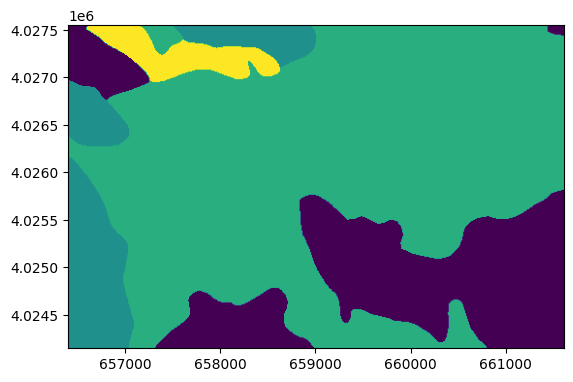

<Axes: >

In [55]:
rst_path='/content/drive/MyDrive/raster_to_be_used/Anafi_rasterized_vector.tif'
from osgeo import gdal
raster = rasterio.open(rst_path)
#raster.RasterCount
show(raster)

In [56]:
# Define the dictionary with pixel values and labels
pixel_dict = labelcreation("/content/drive/MyDrive/LithDatasSHP")

# Set the input folder containing raster files
input_folder = "/content/drive/MyDrive/raster_to_be_used"
output_folder = "/content/drive/MyDrive/finalrasterdata"

def apply_labels(raster_data, pixel_dict):
    """
    This function applies labels to raster data using a dictionary of pixel values and labels.
    
    Parameters:
    raster_data (numpy.ndarray): The raster data as a 2D numpy array.
    pixel_dict (dict): A dictionary mapping pixel values to their corresponding labels.
    
    Returns:
    numpy.ndarray: A 2D numpy array with the same shape as the input raster_data, 
                   but with pixel values replaced by their corresponding labels.
    """
    labeled_data = np.full(raster_data.shape, 0, dtype=np.int32)
    for pixel_value, label in pixel_dict.items():
        labeled_data[raster_data == pixel_value] = pixel_value
    return labeled_data

# Iterate through the files in the folder
for filename in os.listdir(input_folder):
    if filename.endswith(".tif"):  # Assuming your raster files have a .tif extension
        input_file_path = os.path.join(input_folder, filename)
        output_file_path = os.path.join(output_folder, f'labeled_{filename}')

        # Read the raster data
        with rasterio.open(input_file_path) as src:
            raster_data = src.read(1)
            profile = src.profile

        # Apply the labels
        labeled_data = apply_labels(raster_data, pixel_dict)

        # Save the labeled raster data as a GeoTIFF
         # Save the labeled raster data as a GeoTIFF
        with rasterio.open(output_file_path, "w", **profile) as dst:
             dst.write(labeled_data, 1)

                 # Update the metadata
             dst.update_tags(
             photometric='MINISBLACK',
             samplesperpixel=1,
             extrasamples='UNSPECIFIED'
        )

        # Save the label information to a text file
        label_file_path = output_file_path.replace(".tif", ".txt")
        with open(label_file_path, "w") as label_file:
            unique_pixel_values = np.unique(labeled_data)
            for pixel_value in unique_pixel_values:
                label = pixel_dict.get(pixel_value, "unknown")
                label_file.write(f"{pixel_value}: {label}\n")

The apply_labels function  applies labels to raster data using a dictionary of pixel values and labels. The function takes a 2D numpy array of raster data and a dictionary mapping pixel values to their corresponding labels as input. It returns a 2D numpy array with the same shape as the input raster_data, but with pixel values replaced by their corresponding labels.

The script then iterates through the files in the input folder, reads the raster data using the rasterio library, and applies the labels to the raster data using the apply_labels function. The labeled raster data is then saved as a GeoTIFF, and the label information is saved to a text file.

In [57]:
def check_labels(file_path, pixel_dict):
    """
    This function checks the label information in the text file against the expected labels in the pixel_dict.
    
    Parameters:
    file_path (str): The path to the GeoTIFF file with labeled raster data.
    pixel_dict (dict): A dictionary mapping pixel values to their corresponding labels.
    """
    label_file_path = file_path.replace(".tif", ".txt")

    if not os.path.exists(label_file_path):
        print(f"Label information file not found: {label_file_path}")
        return

    # Read the label information from the text file
    with open(label_file_path, "r") as label_file:
        label_info = {}
        for line in label_file:
            pixel_value, label = line.strip().split(": ")
            label_info[int(pixel_value)] = label

    # Read the raster data with rasterio
    with rasterio.open(file_path) as src:
        raster_data = src.read(1)

    # Check the labels for each pixel value
    for pixel_value, label in pixel_dict.items():
        expected_label = label
        actual_label = label_info.get(pixel_value)
        
        if actual_label is not None and actual_label != expected_label and actual_label != 'nan':
            print(f"Incorrect label found for pixel value {pixel_value}:")
            print("  Expected label:", expected_label)
            print("  Actual label:", actual_label)
            print()

# Iterate through the files in the folder
for filename in os.listdir(output_folder):
    if filename.startswith("labeled_") and filename.endswith(".tif"):
        output_file_path = os.path.join(output_folder, filename)
        print(f"Checking labels for {output_file_path}:")
        check_labels(output_file_path, pixel_dict)
        print()



Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Desfina_A_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Agios_Georgios_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Amfilochia_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Anafi_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Desfina_B_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Crete_B_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Crete_A_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Ermoupoli_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Grevena_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Exarchos_rasterized_vector.t

The check_labels function  checks the label information in the text file against the expected labels in the pixel_dict. The function takes the path to the GeoTIFF file with labeled raster data and a dictionary mapping pixel values to their corresponding labels as input.

The function reads the label information from the text file and the raster data with rasterio. It then checks the labels for each pixel value in the pixel_dict, printing the expected label and whether the label information file contains the correct label.

The script then iterates through the files in the output folder and calls the check_labels function for each labeled GeoTIFF file to verify that the labels were applied correctly.

In [58]:
def check_labels(file_path, pixel_dict):
    """
    This function checks the label information in the text file against the expected labels in the pixel_dict.
    
    Parameters:
    file_path (str): The path to the GeoTIFF file with labeled raster data.
    pixel_dict (dict): A dictionary mapping pixel values to their corresponding labels.
    """
    label_file_path = file_path.replace(".tif", ".txt")

    if not os.path.exists(label_file_path):
        print(f"Label information file not found: {label_file_path}")
        return

    # Read the label information from the text file
    with open(label_file_path, "r") as label_file:
        label_info = {}
        for line in label_file:
            pixel_value, label = line.strip().split(": ")
            label_info[int(pixel_value)] = label

    # Read the raster data with rasterio
    with rasterio.open(file_path) as src:
        raster_data = src.read(1)

    # Check the labels for each pixel value
    for pixel_value, label in pixel_dict.items():
        expected_label = label
        actual_label = label_info.get(pixel_value)
        
        if actual_label is not None and actual_label != expected_label and actual_label != 'nan':
            print(f"Incorrect label found for pixel value {pixel_value}:")
            print("  Expected label:", expected_label)
            print("  Actual label:", actual_label)
            print()

# Iterate through the files in the folder
for filename in os.listdir(output_folder):
    if filename.startswith("labeled_") and filename.endswith(".tif"):
        output_file_path = os.path.join(output_folder, filename)
        print(f"Checking labels for {output_file_path}:")
        check_labels(output_file_path, pixel_dict)
        print()


Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Desfina_A_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Agios_Georgios_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Amfilochia_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Anafi_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Desfina_B_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Crete_B_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Crete_A_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Ermoupoli_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Grevena_rasterized_vector.tif:

Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Exarchos_rasterized_vector.t